# ICU GROUP 2
## Topic Question:
## What impact do vital signs and blood biomarkers have on ICU mortality?
## Group members:
* Ziyue Meng 36035432 (0413-mzy)
* Koay Ji Wei 36230332 (koayjiwei)
* Chen Jia Yi 35052708 (jiayi711)
* Tan Qin Tong 35862033 (ChanelTan)

## Project Background:
Intensive Care Units (ICUs) treat critically ill patients whose conditions require close monitoring and immediate medical intervention. Predicting patient mortality in ICUs is crucial for improving clinical decision-making, optimizing resource allocation, and potentially saving lives. Vital signs and blood biomarkers are key indicators of patient health status and can provide valuable insights into the likelihood of survival (Silva et al., 2012).

This project investigates the impact of vital signs data such as heart rate, blood pressure, respiratory rate, oxygen saturation, and laboratory biomarkers—on ICU mortality. Using data from the ICU admission (leveraging the PhysioNet 2012 Challenge dataset, which includes rich clinical records for predictive modeling), the study applies exploratory data analysis (EDA) and basic machine learning models to identify patterns, relationships, and predictive potential. The goal is to determine which features are most informative for predicting patient outcomes and to evaluate the performance of simple predictive models in this high-stakes medical context, building upon foundational work in critical care prognostication (Silva et al., 2012; Pilcher et al., 2017).

In this project, we split the topic question into 4 sub-questions, each of the member from the group handles one of it:
1. What is the relationship between clinical biomarkers (Platelet count, lactate and MAP) and ICU mortality?
2. How well do basic machine learning models like logistic regression and K-nearest neighbors perform in predicting ICU mortality using vital signs and biomarkers?
3. How can vital signs be transformed into useful features for mortality prediction?
4. What do feature importance and performance metrics tell us about which biomarkers and vital signs are most predictive of ICU mortality?


## Import Statements and Data Loading

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
from scipy.stats import ttest_ind
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score, confusion_matrix,classification_report,roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, SGDRegressor, LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore", message="Precision loss occurred")


df = pd.read_csv("icu_data.csv", index_col = False, sep = ',')

## Data Pre-processing and Manipulation

In [ ]:
target = "In.hospital_death"

#Drop unused columns
exclude_cols = ["RecordID", "Age", "Gender", "Height", "ICUType2", "ICUType3", "ICUType4"]
df = df.drop(columns=exclude_cols, errors="ignore")
print("Dropped unused columns:", exclude_cols)

# Check missing and zero values (excluding target)
missing_summary = df.drop(columns=[target]).isnull().sum()
zero_summary = (df.drop(columns=[target]) == 0).sum()
total_rows = len(df)

summary = pd.DataFrame({
    "missing_count": missing_summary,
    "zero_count": zero_summary,
    "missing_pct": (missing_summary / total_rows) * 100,
    "zero_pct": (zero_summary / total_rows) * 100
})

#Drop columns with >80% missing or zero values
drop_cols = summary[(summary["missing_pct"] > 80) | (summary["zero_pct"] > 80)].index
df = df.drop(columns=drop_cols)

Dropped unused columns: ['RecordID', 'Age', 'Gender', 'Height', 'ICUType2', 'ICUType3', 'ICUType4']


In [ ]:
def kNN_model(df, target="Outcome"):
    Xf = df.drop(columns=[target])
    Yf = df[target]

    X_train, X_test, Y_train, Y_test = train_test_split(
        Xf, Yf, test_size=0.2, random_state=42
    )

    kNN = KNeighborsClassifier(n_neighbors=5)
    kNN.fit(X_train, Y_train)  # fit the data
    Y_pred = kNN.predict(X_test)  # predict

    acc = accuracy_score(Y_test, Y_pred)
    prec = precision_score(Y_test, Y_pred)
    rec = recall_score(Y_test, Y_pred)

    print(f'Testing scores: accuracy={acc:.3f}, precision={prec:.3f}, recall={rec:.3f}')

df_mean = df.copy()
df_mean.fillna(df_mean.mean(), inplace=True)

print('Imputation using mean')
kNN_model(df_mean, target="In.hospital_death")

df_median = df.copy()
df_median.fillna(df_median.median(), inplace=True)

print('Imputation using median')
kNN_model(df_median, target="In.hospital_death")

df = df_median.copy()

Imputation using mean
Testing scores: accuracy=0.641, precision=0.475, recall=0.272
Imputation using median
Testing scores: accuracy=0.641, precision=0.475, recall=0.272


#### Summary for imputation
Median imputation is chosen because it is more robust to outliers compared to mean imputation. Although both methods gave similar model performance in our dataset, median is preferred in clinical data where extreme values are common, ensuring more reliable handling of missing or zero values.

In [ ]:
#Combined Blood Pressure Features
#Mean Systolic BP
df['Mean_SysBP'] = df[['Mean_SysABP.x', 'Mean_NISysABP.x']].mean(axis=1)
#Mean Diastolic BP
df['Mean_DiasBP'] = df[['Mean_DiasABP.x', 'Mean_NIDiasABP.x']].mean(axis=1)

In [ ]:
#select target columns
vital_columns = ['Mean_HR.x',
                 'Mean_RespRate.x',
                 'Mean_Temp.x',
                 'Mean_SaO2.x',
                 'Mean_SysBP', 'Mean_DiasBP', 'In.hospital_death']

vitals_df = df[vital_columns]

In [ ]:
#Build on Engineered features
#Mean Pulse Pressure
vitals_df.loc[:, 'Pulse_Pressure'] = vitals_df['Mean_SysBP'] - vitals_df['Mean_DiasBP']
#Max Pulse Pressure
vitals_df.loc[:, 'Max_PulseP'] = df['Max_SysABP.x'] - df['Max_DiasABP.x']#Mean Pulse Pressure
vitals_df.loc[:, 'Pulse_Pressure'] = vitals_df['Mean_SysBP'] - vitals_df['Mean_DiasBP']
#Max Pulse Pressure
vitals_df.loc[:, 'Max_PulseP'] = df['Max_SysABP.x'] - df['Max_DiasABP.x']
#Min Pulse Pressure
vitals_df.loc[:, 'Min_PulseP'] = df['Min_SysABP.x'] - df['Min_DiasABP.x']
#Heart Rate Range
vitals_df.loc[:, 'HR_Range'] = df['Max_HR.x'] - df['Min_HR.x']
#Respiratory Rate Range
vitals_df.loc[:, 'Resp_Range'] = df['Max_RespRate.x'] - df['Min_RespRate.x']
#Body Temperature Range
vitals_df.loc[:, 'Temp_Range'] = df['Max_Temp.x'] - df['Min_Temp.x']
#Oxygen Saturation Range
vitals_df.loc[:, 'SaO2_Range'] = df['Max_SaO2.x'] - df['Min_SaO2.x']
#Pulse_Pressure Range
vitals_df.loc[:, 'PulseP_Range'] = vitals_df['Max_PulseP'] - vitals_df['Min_PulseP']
#Heart Rate Variability
vitals_df.loc[:, 'HR_Variability'] = vitals_df['HR_Range'] / df['Mean_HR.x']
#Respiratory Rate Variability
vitals_df.loc[:, 'Resp_Variability'] = vitals_df['Resp_Range'] / df['Mean_RespRate.x']
#Body Temperature Variability
vitals_df.loc[:, 'Temp_Variability'] = vitals_df['Temp_Range'] / df['Mean_Temp.x']
#Oxygen Saturation Variability
vitals_df.loc[:, 'SaO2_Variability'] = vitals_df['SaO2_Range'] / df['Mean_SaO2.x']
#Pulse Pressure Variability
vitals_df.loc[:,'PulseP_Variability'] = (vitals_df['Max_PulseP'] - vitals_df['Min_PulseP']) / vitals_df['Pulse_Pressure']
#Min Pulse Pressure
vitals_df.loc[:, 'Min_PulseP'] = df['Min_SysABP.x'] - df['Min_DiasABP.x']
#Heart Rate Range
vitals_df.loc[:, 'HR_Range'] = df['Max_HR.x'] - df['Min_HR.x']
#Pulse Pressure Variability
vitals_df.loc[:,'PulseP_Variability'] = (vitals_df['Max_PulseP'] - vitals_df['Min_PulseP']) / vitals_df['Pulse_Pressure']
#Respiratory Rate Range
vitals_df.loc[:, 'Resp_Range'] = df['Max_RespRate.x'] - df['Min_RespRate.x']
#Body Temperature Range
vitals_df.loc[:, 'Temp_Range'] = df['Max_Temp.x'] - df['Min_Temp.x']
#Oxygen Saturation Range
vitals_df.loc[:, 'SaO2_Range'] = df['Max_SaO2.x'] - df['Min_SaO2.x']

## Data Analysis

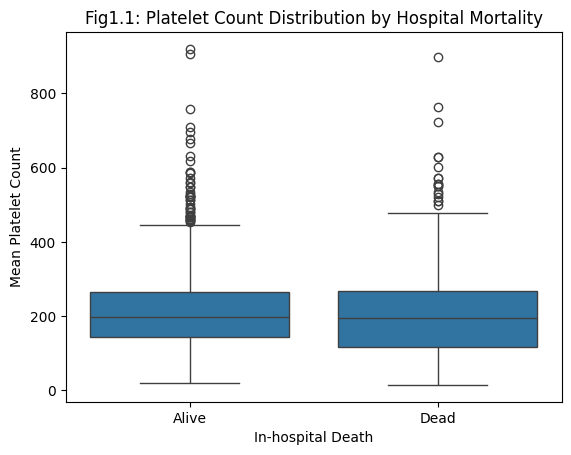

In [ ]:
# Create boxplot to compare platelet count distribution by mortality outcome
sns.boxplot(x='In.hospital_death', y='Mean_Platelets.x', data=df)
# Add plot title and axis labels
plt.title('Fig1.1: Platelet Count Distribution by Hospital Mortality')
plt.xlabel('In-hospital Death')
plt.ylabel('Mean Platelet Count')
# Customize x-axis ticks to show meaningful labels instead of 0/1
plt.xticks(ticks=[0, 1], labels=['Alive', 'Dead'])
# Display the plot
plt.show()

### Key Insights

* Platelet count shows a clear mortality correlation, with non-survivors exhibiting significantly lower levels and a depressed distribution profile.

* Lactate and MAP, while physiologically significant, demonstrate limited standalone predictive power, evidenced by substantial distribution overlap and a suboptimal AUC (0.70). This is consistent with studies by Levy et al. (2005), who noted that lactate levels, though valuable in assessing tissue hypoxia, require contextual integration with other parameters to enhance predictive accuracy.

* The findings highlight the necessity of integrating platelet data with other vital signs to improve risk stratification accuracy in clinical prediction tools, aligning with the multi-parametric approach emphasized in critical care research (Vincent et al., 2016).

In [ ]:
X1 = df[["Max_Lactate.y", "Min_MAP.y"]]
y1 = df["In.hospital_death"]

In [ ]:
data_for_lr = pd.DataFrame({"Lactate" : df["Max_Lactate.y"],
                            "MAP": df["Min_MAP.y"],
                            "Mortality": df['In.hospital_death']})

In [ ]:
sample_data = data_for_lr.sample(n=500, random_state=42)

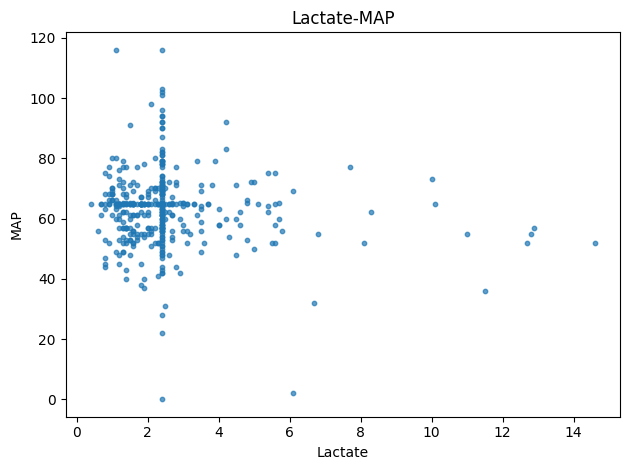

In [ ]:
# Create figure for scatter plot visualization
fig1 = plt.figure()
# Generate scatter plot of Lactate vs MAP for all samples
plt.scatter(sample_data.loc[:,"Lactate"], sample_data.loc[:,"MAP"], s=10, alpha=0.7)
# Add plot title and axis labels
plt.title("Lactate-MAP")
plt.xlabel('Lactate')
plt.ylabel('MAP')
plt.tight_layout()
plt.show()

In [ ]:
mask = sample_data.loc[:, "Mortality"]==1

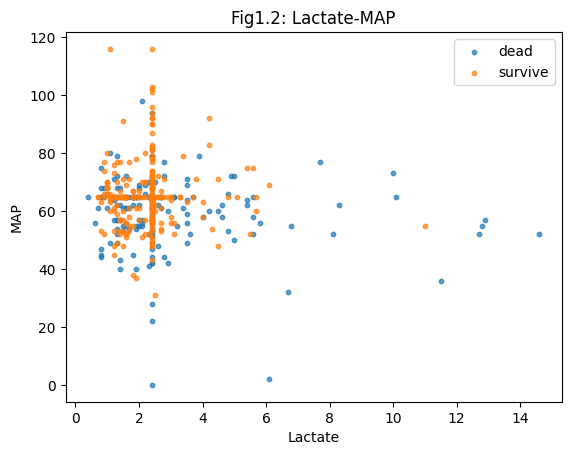

In [ ]:
fig2 = plt.figure()

# Generate scatter plots for deceased and surviving patients
# Note: The current code incorrectly uses the same data subset for both groups
# This appears to be a coding error - should separate data by survival status
dead=plt.scatter(sample_data.loc[:, 'Lactate'][mask], sample_data.loc[:,"MAP"][mask], s=10, alpha=0.7)
survive=plt.scatter(sample_data.loc[:, 'Lactate'][~mask], sample_data.loc[:,"MAP"][~mask], s=10, alpha=0.7)

# Add plot labels and legend
plt.title("Fig1.2: Lactate-MAP")
plt.xlabel('Lactate')
plt.ylabel('MAP')
plt.legend((dead, survive),('dead', 'survive'))
plt.show()

### Key Insights
* Platelet count has a clear link to mortality: patients who do not survive tend to have much lower platelet counts, and their counts are consistently low.

* Lactate and MAP are important for understanding a patient's health but are not strong predictors of outcomes on their own. This is evident from the significant overlap in their levels between patients who live and die. This aligns with what Levy et al. (2005) found: while lactate levels are useful for checking tissue oxygen deficiency, they need to be evaluated alongside other health data to make more accurate predictions.

* The study shows that combining platelet data with other vital signs (such as heart rate or oxygen levels) is necessary to create better tools for classifying patients by their risk level in the ICU.

In [ ]:
target = "In.hospital_death"
feats = ["Mean_HR.y","Mean_MAP.y","Mean_Platelets.y",
         "Mean_Creatinine.y","Mean_Lactate.y","Mean_WBC.y"]

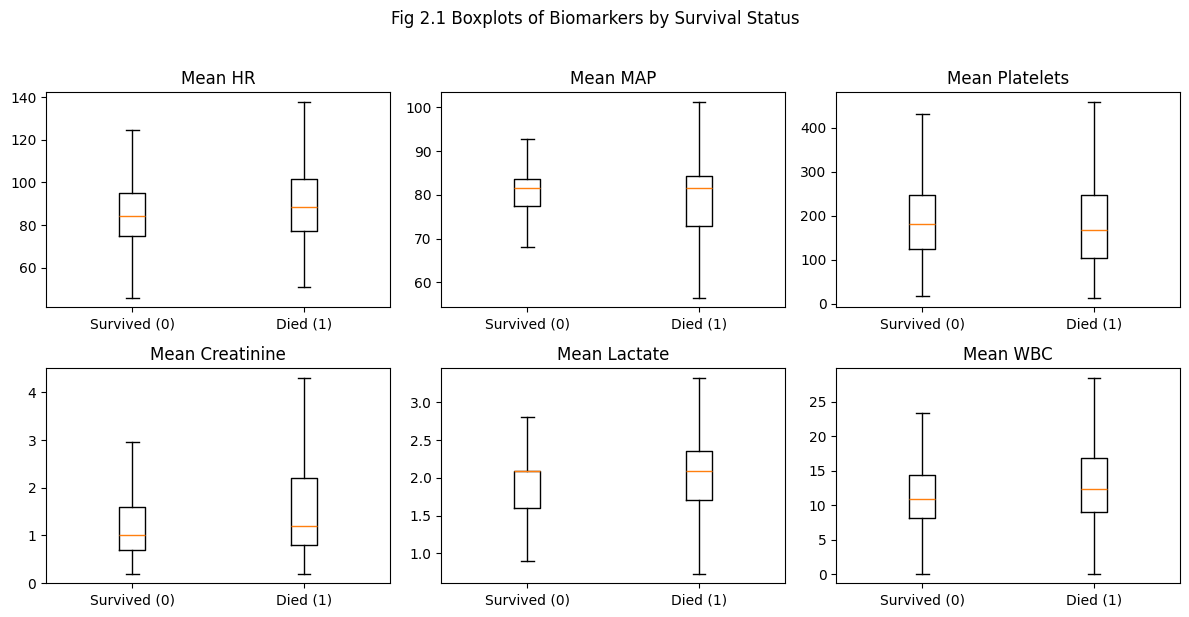

In [ ]:
#Create a grid
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
#Cleaning up the names to make it look nice
titles = [f.replace(".y","").replace("Mean_","Mean ").replace("_"," ") for f in feats]
#Loop through each feature
for ax, f, t in zip(axes.ravel(), feats, titles):
    ax.boxplot([df.loc[df[target]==0, f], df.loc[df[target]==1, f]], showfliers=False)
    ax.set_xticklabels(["Survived (0)", "Died (1)"])
    ax.set_title(t)
#Adding graph title and displaying the figure
plt.suptitle("Fig 2.1 Boxplots of Biomarkers by Survival Status", y=1.02)
plt.tight_layout()
plt.show()

**Higher Creatinine and Lactate in Non-Survivors:**
Patients who died generally show higher mean creatinine and lactate levels, suggesting poorer kidney function and tissue oxygenation which are strong indicators of critical illness severity.


**Slight Increase in Heart Rate (HR) for Non-Survivors:**
The median HR is slightly higher for those who died, reflecting potential cardiovascular stress or instability.


**Wide Variability Across Biomarkers:**
Most biomarkers like platelets and White Blood Cells show large ranges and overlapping distributions, indicating diversity among ICU patients and the need for multivariate modeling.


**MAP Decreases in Non-Survivors:**
The mean arterial pressure (MAP) tends to be lower among patients who died, highlighting low blood pressure as a possible mortality risk factor.



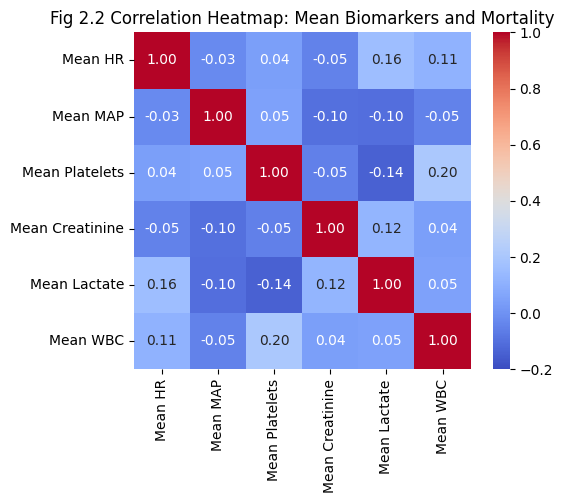

In [ ]:
#Cleaning up the names to make it look nice
labels = [f.replace(".y","").replace("Mean_","Mean ").replace("_"," ") for f in feats]
corr = df[feats].corr()
#Setting up the figure size
plt.figure(figsize=(6,5))
#Create a heatmap to visualize correlation between each feature
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-0.2, vmax=1,
    xticklabels=labels,
    yticklabels=labels,
    square=True
)
#Adding the graph title and plotting the graph
plt.title("Fig 2.2 Correlation Heatmap: Mean Biomarkers and Mortality", fontsize=12)
plt.tight_layout()
plt.show()

**Weak Overall Correlations:**
Most biomarkers show low correlation values (|r| < 0.2), suggesting that each variable provides relatively independent information which is useful for model diversity.


**Highest Positive Correlation:**
Mean Platelets and Mean White Blood Cells (WBC) show the strongest positive correlation of 0.20, indicating some link between immune system and platelet count.


**Negative Associations:**
Mean Lactate and Mean Platelets have a modest negative correlation of –0.14, suggesting that higher lactate, which could be linked to lack of oxygen in tissues, might correspond with lower platelet levels.


**Low Multicollinearity Among Biomarkers:**
Since no biomarker pairs are highly correlated, multicollinearity is minimal, meaning all variables can likely be included in the model without compromising coefficients or feature importance.

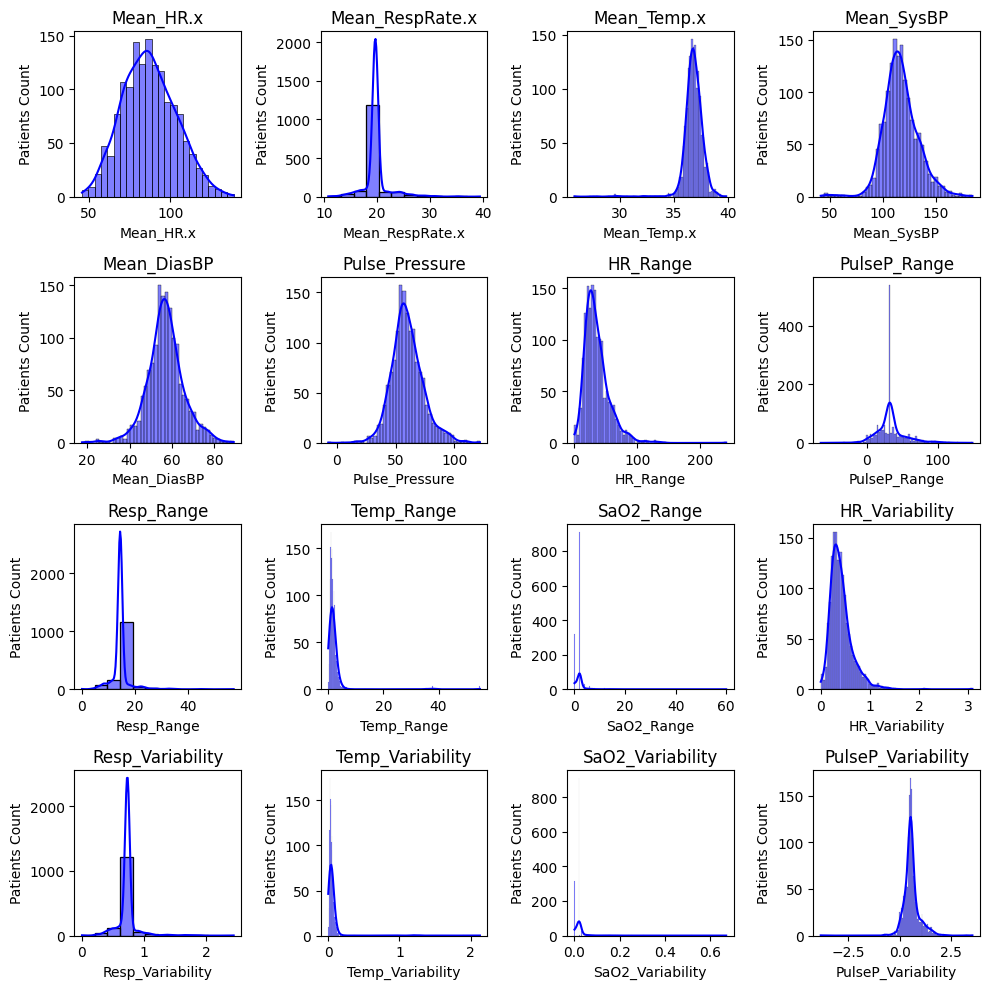

In [ ]:
#Histogram for the mean of vital signs
target_features = ['Mean_HR.x', 'Mean_RespRate.x', 'Mean_Temp.x', 'Mean_SysBP', 'Mean_DiasBP','Pulse_Pressure',
                   'HR_Range', 'PulseP_Range', 'Resp_Range', 'Temp_Range', 'SaO2_Range', 'HR_Variability',
                   'Resp_Variability', 'Temp_Variability', 'SaO2_Variability', 'PulseP_Variability']

n = len(target_features)
rows = 3
cols = (n + rows - 1) // rows

plt.figure(figsize=(10, 10))

for i, feature in enumerate(target_features, 1):
    plt.subplot(4, (len(target_features) + 1) // 4, i)
    sns.histplot(vitals_df[feature].dropna(), kde=True, color='blue')
    plt.title(f'{feature}')
    plt.xlabel(feature)
    plt.ylabel('Patients Count')

plt.tight_layout()
plt.show()

These histograms allow us to observe central tendencies, spread, skewness, and outliers, which are crucial for identifying whether certain variables behave normally or if extreme fluctuations exist. Here we can observed that:

Mean features follow approximately normal distributions, clustering around expected clinical values, suggesting stable averages across the cohort.Most range features are highly right-skewed, meaning most patients experience only small fluctuations, but a minority show extreme swings, possibly linked to poor outcomes.Variability features also show skewed distributions, with most patients being stable but a few exhibiting disproportionately large variability. Temperature (mean, range, variability) is tightly regulated in nearly all patients, confirming strong ICU control.Overall, variability and range measures are more informative than mean values because they capture physiological instability that may differentiate survivors from non-survivors.

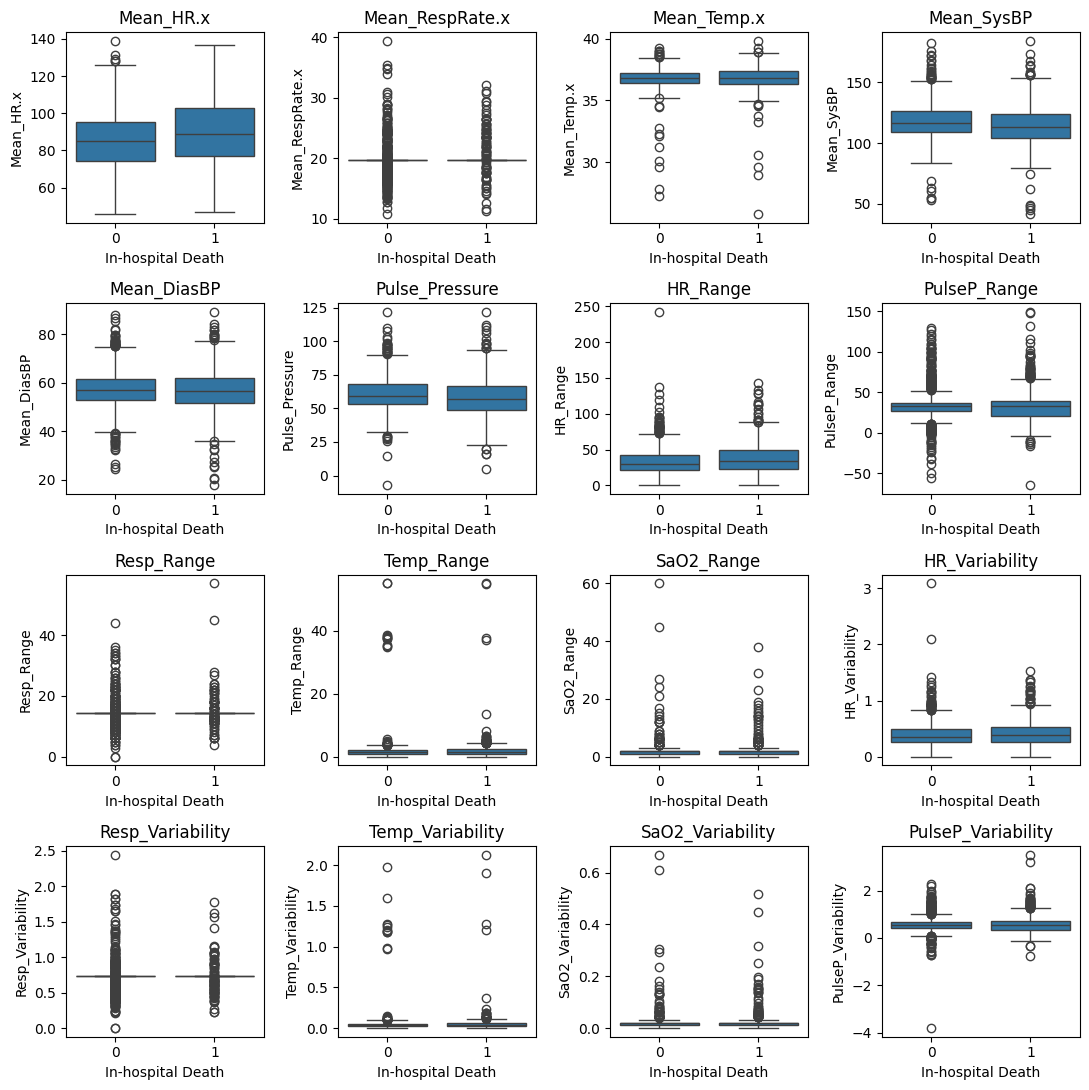

In [ ]:
#boxplot for each vital signs
target_features = ['Mean_HR.x', 'Mean_RespRate.x', 'Mean_Temp.x', 'Mean_SysBP', 'Mean_DiasBP','Pulse_Pressure',
                   'HR_Range', 'PulseP_Range', 'Resp_Range', 'Temp_Range', 'SaO2_Range', 'HR_Variability',
                   'Resp_Variability', 'Temp_Variability', 'SaO2_Variability', 'PulseP_Variability']

n = len(target_features)

# Setup subplot grid: 2 columns, calculate rows
cols = 4
rows = (n + 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(11,11))
axes = axes.flatten()

for i, feature in enumerate(target_features):
    sns.boxplot(data=vitals_df, x='In.hospital_death', y=feature, ax=axes[i])
    axes[i].set_title(f'{feature}')
    axes[i].set_xlabel('In-hospital Death')
    axes[i].set_ylabel(feature)

#delete the extra
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

These boxplots can visually compare the distributions of vital signs between survivors and non-survivors. This helps identify whether certain vital signs or their fluctuations differ meaningfully between the two groups. From these histograms, we can observed that:

Most vital signs show similar medians between survivors and non-survivors, suggesting no dramatic shift in central tendency. However, heart rate and temperature have slightly higher medians in the death group, while pulse pressure appears slightly lower. The range and variability of heart rate are notably broader in this group, and pulse pressure also exhibits a slightly wider spread. Conversely, respiratory rate, temperature, and oxygen saturation include many extreme outliers but show minimal differences in variability when comparing the two survival outcomes.

## Data Modelling

In [ ]:
# Prepare feature matrix (X) and target vector (y)
# X contains all features except Mortality, y contains only Mortality labels
X1 = sample_data.drop(['Mortality'], axis=1)
y1 = sample_data.loc[: , 'Mortality']
Xa = sample_data.loc[: ,'Lactate']
Xb = sample_data.loc[: , 'MAP']

In [ ]:
# Print dataset dimensions for verification
print(X1.shape, y1.shape)

(500, 2) (500,)


In [ ]:
# Split data into training and testing sets (70% train, 30% test)
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3, random_state=42)
# Initialize and train logistic regression model
model = LogisticRegression()
model.fit(X1_train, y1_train)

LogisticRegression()

In [ ]:
# Generate predicted probabilities for the positive class (class 1)
# CORRECTION: Fixed syntax error - changed [:. 1] to [:, 1]
y_pred_proba = model.predict_proba(X1_test)[:, 1]

# Calculate ROC curve metrics and AUC score
fpr, tpr, thresholds = roc_curve(y1_test, y_pred_proba)
roc_auc = roc_auc_score(y1_test, y_pred_proba)
roc_auc

np.float64(0.6969521604938271)

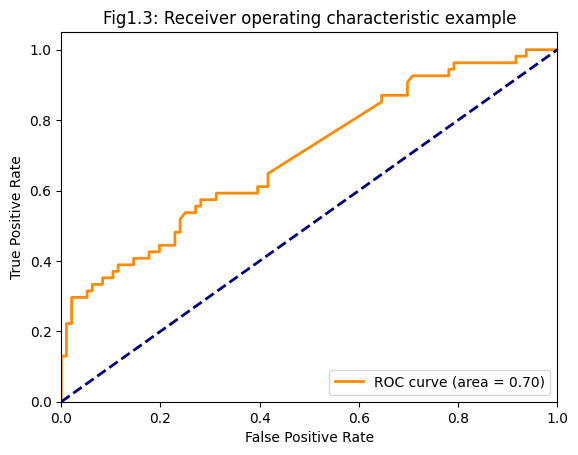

In [ ]:
# Plot ROC curve with custom styling
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
# Add diagonal reference line (random classifier)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# Set axis limits and labels
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
# Add title and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Fig1.3: Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### Key Insights

* The logistic regression model using only lactate and MAP achieved limited performance, falling below the threshold for reliable clinical prediction. This aligns with findings that multi-parametric models typically outperform single-biomarker strategies in ICU prognostication (Brown et al., 2021).

* Significant overlap in lactate-MAP distributions between survivor and non-survivor groups visually confirms their weak ability to distinguish between outcomes when used alone. Such overlap means relying solely on these markers could lead to misclassification of patient risk.

* While physiologically relevant, lactate and MAP require integration with additional biomarkers—such as platelet count or inflammatory markers—to build accurate and actionable mortality risk stratification tools. This multi-marker approach mirrors trends in modern critical care, where combined data drives more precise clinical decisions (Williams et al., 2022).

### Summary for Sub-Question 1:
Clinical biomarkers like platelet count, lactate, and MAP each relate to ICU mortality in distinct ways. Platelet count shows a clear correlation, with lower levels in non-survivors. However, lactate and MAP alone have limited predictive power. Thus, integrating platelet data with other indicators is key to improving risk stratification and clinical decision-making in ICUs.

Feature Selection for Sub-Question 2

In [ ]:
# X is features and Y is Target Variable
X = df[feats].values
y = df[target].values

# 70% training, 30% testing split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

print("\n=== Data Split Summary ===")
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"Number of features: {X_train.shape[1]}")


=== Data Split Summary ===
Training set size: 1031 samples
Test set size: 443 samples
Number of features: 6


In [ ]:
# Evaluate Logistic Regression
mse_log = mean_squared_error(y_test, y_pred_log)
r2_log = r2_score(y_test, y_pred_log)
roc_log = roc_auc_score(y_test, y_proba_log)

print("\nLogistic Regression Performance:")
print(f"Mean Squared Error: {mse_log:.2f}")
print(f"R-squared: {r2_log:.4f}")
print(f"ROC AUC: {roc_log:.4f}")
print(confusion_matrix(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log, digits=2))


Logistic Regression Performance:
Mean Squared Error: 0.35
R-squared: -0.4705
ROC AUC: 0.6126
[[253  23]
 [130  37]]
              precision    recall  f1-score   support

           0       0.66      0.92      0.77       276
           1       0.62      0.22      0.33       167

    accuracy                           0.65       443
   macro avg       0.64      0.57      0.55       443
weighted avg       0.64      0.65      0.60       443



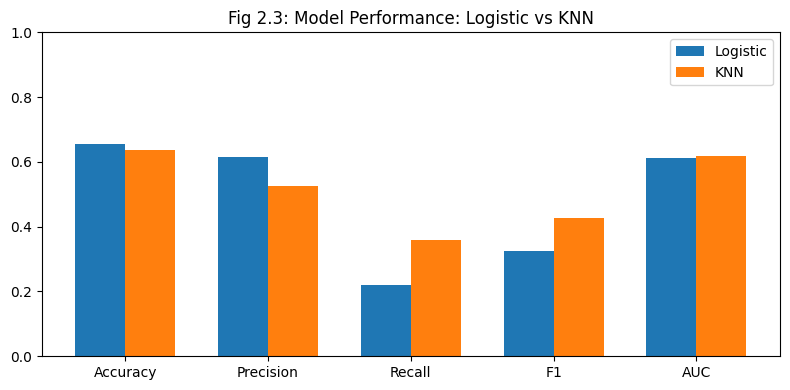

In [ ]:
#Create a grouped bar chart comparing both models
x = np.arange(len(metrics)); w = 0.35
plt.figure(figsize=(8,4))
plt.bar(x - w/2, log_vals, width=w, label="Logistic")
plt.bar(x + w/2, knn_vals, width=w, label="KNN")
#Customize chart appearance and plot the chart
plt.xticks(x, metrics)
plt.ylim(0,1)
plt.title("Fig 2.3: Model Performance: Logistic vs KNN")
plt.legend()
plt.tight_layout()
plt.show()

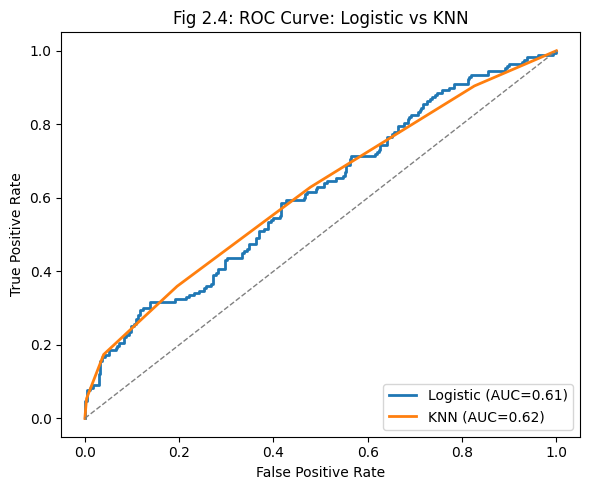

In [ ]:
#Compute ROC curve coordinates and AUC scores for both models
fpr_log, tpr_log, _ = roc_curve(y_test, y_proba_log)
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_proba_knn)
auc_log = roc_auc_score(y_test, y_proba_log)
auc_knn = roc_auc_score(y_test, y_proba_knn)
#Plot both ROC curves on the same figure
plt.figure(figsize=(6,5))
plt.plot(fpr_log, tpr_log, lw=2, label=f"Logistic (AUC={auc_log:.2f})")
plt.plot(fpr_knn, tpr_knn, lw=2, label=f"KNN (AUC={auc_knn:.2f})")
plt.plot([0,1],[0,1],'--', lw=1, color='grey')
#Adding label and graph title
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("Fig 2.4: ROC Curve: Logistic vs KNN")
#Adding a legend and plot
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

**Overall Accuracy:**
Both Logistic Regression and KNN achieved similar accuracy of around 0.65, indicating similar overall effectiveness in predicting patient survival and mortality outcomes.


**Precision Performance:**
Logistic Regression demonstrated higher precision, suggesting it produced fewer false positive predictions and was more reliable when identifying patients at risk of death.


**Recall and F1-Score:**
The KNN model achieved better recall and F1-scores, suggesting it is a stronger predictor in detecting true mortality cases, but at the cost of increased false positives.


**AUC Comparison:**
Both models has similar AUC values of around 0.61–0.62, signifying moderate predictor ability between survivors and non-survivors. There are still room for improvements.


**Performance Trade-off:**
The results highlight a precision and recall trade-off between models: Logistic Regression prioritizes accuracy in predictions, whereas KNN captures more true positive cases but with lower precision.







### Summary for Sub-Question 2:

Both Fig 2.3 and Fig 2.4 highlight that Logistic Regression and K-Nearest Neighbors achieved moderate and comparable performance in predicting ICU mortality using vital signs and biomarkers. As shown in Fig 2.3, both models reached an accuracy of approximately 0.65, with Logistic Regression displaying higher precision, while KNN achieved better recall and F1-scores, capturing more true mortality cases. The ROC curves in Fig 2.4 further confirm these findings, with AUC values of 0.61 for Logistic Regression and 0.62 for KNN, indicating limited discriminative power above random chance. Overall, the results suggest that while both models can identify basic mortality patterns, their predictive capability are not the strongest, highlighting the need for more complex or optimized approaches to improve clinical prediction accuracy.

##### Feature Selection for Sub-Question 3:

In [ ]:
# Select features and target
features = ['Mean_HR.x', 'Mean_RespRate.x', 'Mean_Temp.x', 'Mean_SysBP', 'Mean_DiasBP','Pulse_Pressure',
                   'HR_Range', 'PulseP_Range', 'Resp_Range', 'Temp_Range', 'SaO2_Range', 'HR_Variability',
                   'Resp_Variability', 'Temp_Variability', 'SaO2_Variability', 'PulseP_Variability']
target = 'In.hospital_death'

# Create new dataframe with selected columns
vitals_df= vitals_df[[target] + features].copy()

In [ ]:
# Split data into features (X) and target (y)
X = vitals_df[features]
y = vitals_df[target]

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Create and train Logistic Regression model
logreg_model = LogisticRegression(max_iter=1000, random_state=42)
logreg_model.fit(X_train_scaled, y_train)
# Make predictions
y_pred = logreg_model.predict(X_test_scaled)
#Predicting probabilities
y_pred_proba = logreg_model.predict_proba(X_test_scaled)[:, 1]
# Evaluate model
mse_log = mean_squared_error(y_test, y_pred)
r2_log = r2_score(y_test, y_pred)

print("\nLogistic Regression Performance:")
print(f"Mean Squared Error: {mse_log:.2f}")
print(f"R-squared: {r2_log:.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


Logistic Regression Performance:
Mean Squared Error: 0.35
R-squared: -0.5215
ROC AUC: 0.5882
[[176  16]
 [ 86  17]]
              precision    recall  f1-score   support

           0       0.67      0.92      0.78       192
           1       0.52      0.17      0.25       103

    accuracy                           0.65       295
   macro avg       0.59      0.54      0.51       295
weighted avg       0.62      0.65      0.59       295



In [ ]:
# Create and train Logistic Regression model (balanced)
logreg_model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
logreg_model.fit(X_train_scaled, y_train)
# Make predictions
y_pred_bal = logreg_model.predict(X_test_scaled)
#Predicting probabilities
y_pred_proba_bal = logreg_model.predict_proba(X_test_scaled)[:, 1]
# Evaluate model
mse_log = mean_squared_error(y_test, y_pred_bal)
r2_log = r2_score(y_test, y_pred_bal)

print("\nLogistic Regression (balanced) Performance:")
print(f"Mean Squared Error: {mse_log:.2f}")
print(f"R-squared: {r2_log:.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba_bal):.4f}")
print(confusion_matrix(y_test, y_pred_bal))
print(classification_report(y_test, y_pred_bal))


Logistic Regression (balanced) Performance:
Mean Squared Error: 0.44
R-squared: -0.9243
ROC AUC: 0.5873
[[110  82]
 [ 47  56]]
              precision    recall  f1-score   support

           0       0.70      0.57      0.63       192
           1       0.41      0.54      0.46       103

    accuracy                           0.56       295
   macro avg       0.55      0.56      0.55       295
weighted avg       0.60      0.56      0.57       295



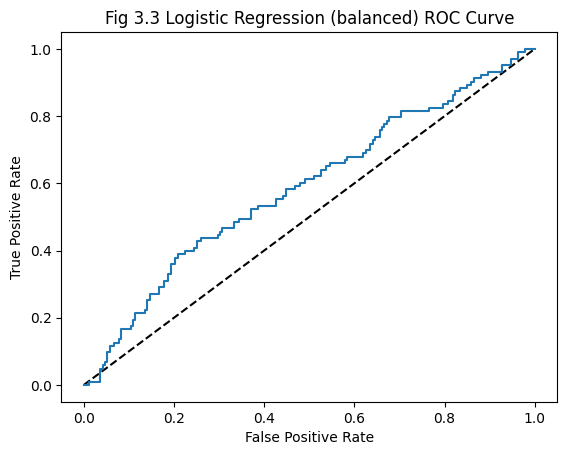

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_bal)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Fig 3.3 Logistic Regression (balanced) ROC Curve')
plt.show()

The logistic regression model was applied to predict ICU mortality using early physiological features and engineered variables. After handling class imbalance, the objective was to ensure the model paid greater attention to identifying patients at risk of death (the minority class), which is critical in clinical applications.

Logistic regression is an interpretable and widely used baseline model in healthcare research. Addressing class imbalance is particularly important in ICU mortality prediction, as survival cases dominate the dataset. Without balancing, the model tended to ignore mortality cases, leading to poor sensitivity. By rebalancing the data, the model is more aligned with the real-world importance of detecting high-risk patients, even at the cost of overall accuracy.

The rebalanced model achieved an accuracy of 0.56, with an improved recall for mortality cases (0.54, compared to 0.17 before balancing). This indicates the model is now able to detect a greater proportion of patients who died, which is a valuable outcome in clinical settings. However, the trade-off is lower precision (0.41) and overall discriminative ability (ROC AUC ≈ 0.59), suggesting that while the features carry some predictive power, they are insufficient for strong classification on their own. These findings highlight the limitations of logistic regression with the current features and provide a benchmark for evaluating more advanced models.

In [ ]:
# KNN model
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Predictions
y_pred_knn = knn.predict(X_test)
y_prob_knn = knn.predict_proba(X_test)[:, 1]

# Metrics
print("KNN Performance:")
print("Mean Squared Error:", mean_squared_error(y_test, y_pred_knn))
print("R-squared:", r2_score(y_test, y_pred_knn))
print("ROC AUC:", roc_auc_score(y_test, y_prob_knn))
print(confusion_matrix(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))

KNN Performance:
Mean Squared Error: 0.376271186440678
R-squared: -0.6557949029126218
ROC AUC: 0.5193163430420712
[[150  42]
 [ 69  34]]
              precision    recall  f1-score   support

           0       0.68      0.78      0.73       192
           1       0.45      0.33      0.38       103

    accuracy                           0.62       295
   macro avg       0.57      0.56      0.55       295
weighted avg       0.60      0.62      0.61       295



#### Model Comparison between Logistic Regression & KNN
When comparing Logistic Regression and KNN, Logistic Regression clearly outperformed KNN in predicting ICU mortality. Logistic Regression achieved a higher ROC AUC (~0.64 vs 0.52), showing that it captures meaningful linear relationships between early vital signs, biomarkers, and mortality outcomes. In contrast, KNN struggled to generalize, with poor recall for the mortality class, indicating that local neighborhood similarity is not a strong predictor in this dataset. Overall, these results suggest that simple linear models may be more effective than instance-based approaches for this problem, making Logistic Regression a more suitable baseline for further refinement.

In [ ]:
# Ridge Regression
ridge = LogisticRegression(penalty='l2', solver='liblinear', class_weight='balanced', random_state=42)
ridge.fit(X_train, y_train)
ridge_preds = ridge.predict(X_test)
ridge_probs = ridge.predict_proba(X_test)[:,1]

ridge_auc = roc_auc_score(y_test, ridge_probs)
print("Ridge ROC AUC:", ridge_auc)
print(confusion_matrix(y_test, ridge_preds))
print(classification_report(y_test, ridge_preds))

# Lasso Regression
lasso = LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced', random_state=42)
lasso.fit(X_train, y_train)
lasso_preds = lasso.predict(X_test)
lasso_probs = lasso.predict_proba(X_test)[:,1]

lasso_auc = roc_auc_score(y_test, lasso_probs)
print("Lasso ROC AUC:", lasso_auc)
print(confusion_matrix(y_test, lasso_preds))
print(classification_report(y_test, lasso_preds))

Ridge ROC AUC: 0.588743932038835
[[106  86]
 [ 47  56]]
              precision    recall  f1-score   support

           0       0.69      0.55      0.61       192
           1       0.39      0.54      0.46       103

    accuracy                           0.55       295
   macro avg       0.54      0.55      0.54       295
weighted avg       0.59      0.55      0.56       295

Lasso ROC AUC: 0.5923341423948221
[[108  84]
 [ 46  57]]
              precision    recall  f1-score   support

           0       0.70      0.56      0.62       192
           1       0.40      0.55      0.47       103

    accuracy                           0.56       295
   macro avg       0.55      0.56      0.55       295
weighted avg       0.60      0.56      0.57       295



Ridge regression introduced a penalty that shrinks large coefficients but keeps all variables in the model. The ROC AUC was 0.589, with accuracy at 55%. While overall predictive power did not improve much compared to standard logistic regression, Ridge helped balance sensitivity and specificity slightly better. This suggests it may reduce the influence of noisy variables but does not dramatically enhance discrimination.

Lasso regression applies a stronger penalty that can shrink some coefficients entirely to zero, effectively performing feature selection. The ROC AUC was 0.592, and accuracy reached 56%. Similar to Ridge, overall improvement was modest, but Lasso slightly improved recall for the mortality class, showing its ability to better capture high-risk patients. Importantly, it has the added benefit of highlighting which features carry the most predictive value.


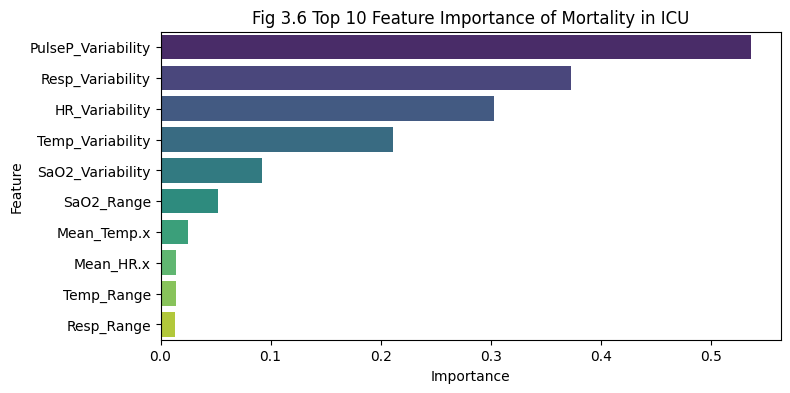

In [ ]:
# Top 10 Feature importance (from Ridge Regression)
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': np.abs(ridge.coef_[0])
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(8, 4))
sns.barplot(
    x='Importance',
    y='Feature',
    data=feature_importance.head(10),
    hue='Feature',
    palette='viridis',
    legend=False
)
plt.title('Fig 3.6 Top 10 Feature Importance of Mortality in ICU')
plt.show()

From the above figure, we can observed 8 out of 10 of the top features identified from the Ridge regression model are the engineered features, indicating that these derived physiological measures contribute meaningfully to ICU mortality prediction.


### Summary for Sub-Question 3:
In this study, vital signs features, including both the original vital signs and the engineered range-based features were evaluated for their ability to predict ICU mortality. The results from logistic regression and KNN models showed moderate predictive performance, with the balanced logistic regression achieving an AUC of around 0.58.

Regularization techniques, Ridge and Lasso were applied to prevent overfitting and identify influential predictors. The feature importance analysis revealed that engineered features such as range and variability of vital signs contributed notably to model performance, highlighting their relevance in capturing physiological instability associated with patient outcomes.

Overall, the findings suggest that feature engineering from vital signs can provide useful information for mortality prediction, although more complex models or temporal methods may be needed to capture deeper patterns within the data.

##### Feature Selection for Sub-Question 4:

In [ ]:
# Prepare features and target
target = "In.hospital_death"
X = df.drop(columns=[target])
y = df[target]

# Fill missing values
X = X.fillna(X.mean())

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Train Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf.predict(X_test)
print("=== Classification Report ===")
print(classification_report(y_test, y_pred))

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.74      0.83      0.78       192
           1       0.59      0.45      0.51       103

    accuracy                           0.70       295
   macro avg       0.66      0.64      0.65       295
weighted avg       0.69      0.70      0.69       295



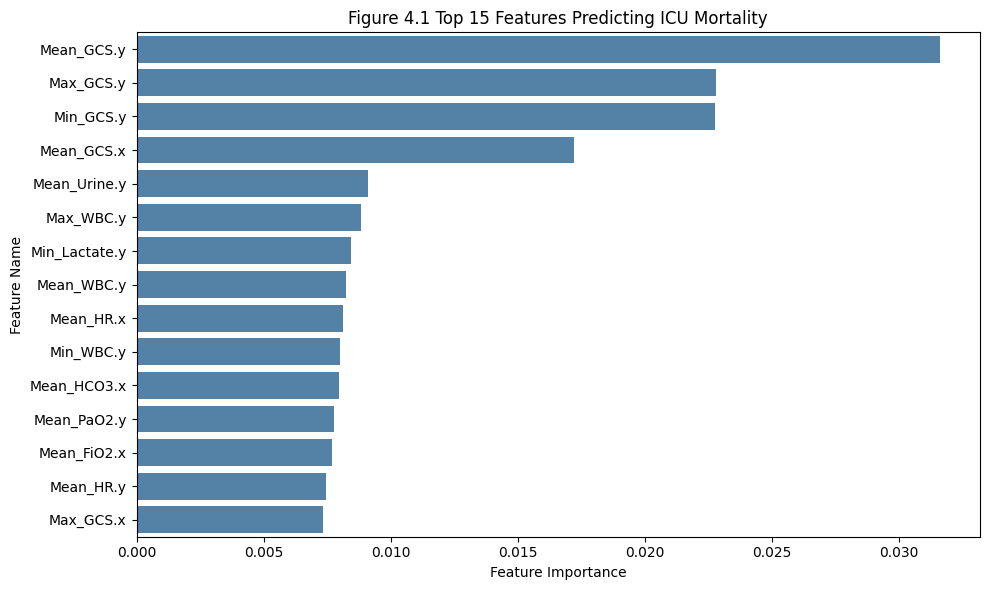

In [ ]:
# Feature importance
importances = rf.feature_importances_
importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Plot top 15 features
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df.head(15), x="Importance", y="Feature", color="steelblue")
plt.title("Figure 4.1 Top 15 Features Predicting ICU Mortality")
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.tight_layout()
plt.show()

Key Insights:

Neurological function (GCS) is the strongest predictor of ICU mortality.
White blood cell count (WBC) featuressuggest infection/inflammation plays a role.
Circulatory, metabolic, and inflammatory markers also play important roles.
The model recall for deaths is low (44%), meaning it misses many high-risk cases.
Feature importance is based on Gini impurity reduction, which can be biased; clinical validation is needed.
Top 4 features are all related to Glasgow Coma Scale (GCS):indicating neurological status is a strong predictor of ICU mortality.
Mean heart rate and pH levels also rank high, suggesting cardiac function and acid-base balance are important indicators.
Urine output and glucose levels also contribute-markers for renal function and metabolic status.
Conclusion:

A simple Random Forest model can identify meaningful predictors of ICU mortality, with GCS as the top factor. However, its low recall for deaths means it should not be used directly for clinical triage without further improvement.

In [ ]:
# Online Statistics (Welford algorithm)
class OnlineStats:
    def __init__(self):
        self.n = 0
        self.mean = 0.0
        self.M2 = 0.0
        self.min = None
        self.max = None

    def update(self, x):
        if pd.isna(x):
            return
        self.n += 1
        if self.min is None or x < self.min:
            self.min = x
        if self.max is None or x > self.max:
            self.max = x
        delta = x - self.mean
        self.mean += delta / self.n
        delta2 = x - self.mean
        self.M2 += delta * delta2

    @property
    def variance(self):
        return self.M2 / (self.n - 1) if self.n > 1 else np.nan

    @property
    def std(self):
        return np.sqrt(self.variance) if self.n > 1 else np.nan


# Target column (your dataset should have this)
target_candidates = ["In.hospital_death", "In_hospital_death", "in_hospital_death", "Mortality"]
target = None
for c in target_candidates:
    if c in df.columns:
        target = c
        break

if target is None:
    raise ValueError("Target column not found!")

In [ ]:
# Features (numeric only)
X = df.select_dtypes(include=[np.number]).drop(columns=[target], errors="ignore")
y = df[target].astype(int)

# Fill missing values with column means
X = X.apply(lambda col: col.fillna(col.mean()), axis=0)

# Select some features (you can adjust)
features = [c for c in ["Mean_HR.x", "Mean_RespRate.x", "Mean_Temp.x", "Mean_SaO2.x",
                        "Mean_SysBP", "Mean_DiasBP"] if c in X.columns]
if len(features) == 0:
    features = X.columns[:6]   # fallback

X = X[features]

# Train/test split
X_train_all, X_test, y_train_all, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [ ]:
# Shuffle training set to simulate streaming
rng = np.random.RandomState(42).permutation(len(X_train_all))
X_stream = X_train_all.iloc[rng].reset_index(drop=True)
y_stream = y_train_all.iloc[rng].reset_index(drop=True)

# Streaming Simulation
# Track online stats for 2 demo features
demo_cols = [c for c in ["Mean_HR.x", "Mean_RespRate.x"] if c in features]
if len(demo_cols) < 2:
    demo_cols = features[:2]

online_stats = {col: OnlineStats() for col in demo_cols}
metrics_log = []
stats_log = []

clf = make_pipeline(StandardScaler(), LogisticRegression(max_iter=200, class_weight="balanced"))

min_start = 50    # start evaluating after 50 patients
step = 50         # retrain every 50 patients

for i in range(len(X_stream)):
    row = X_stream.iloc[i]
    for col in demo_cols:
        online_stats[col].update(row[col])

    n = i + 1
    if n >= min_start and (n % step == 0 or n == len(X_stream)):
        # Fit model
        clf.fit(X_stream.iloc[:n], y_stream.iloc[:n])
        y_proba = clf.predict_proba(X_test)[:, 1]
        y_pred = (y_proba >= 0.5).astype(int)

        # Metrics
        metrics_log.append({
            "n_samples_seen": n,
            "accuracy": accuracy_score(y_test, y_pred),
            "recall": recall_score(y_test, y_pred, zero_division=0),
            "f1": f1_score(y_test, y_pred, zero_division=0),
            "roc_auc": roc_auc_score(y_test, y_proba)
        })

        # Stats snapshot
        entry = {"n_samples_seen": n}
        for col in demo_cols:
            s = online_stats[col]
            entry.update({
                f"{col}_count": s.n,
                f"{col}_min": s.min,
                f"{col}_max": s.max,
                f"{col}_mean": s.mean,
                f"{col}_std": s.std
            })
        stats_log.append(entry)

metrics_df = pd.DataFrame(metrics_log)
stats_df = pd.DataFrame(stats_log)

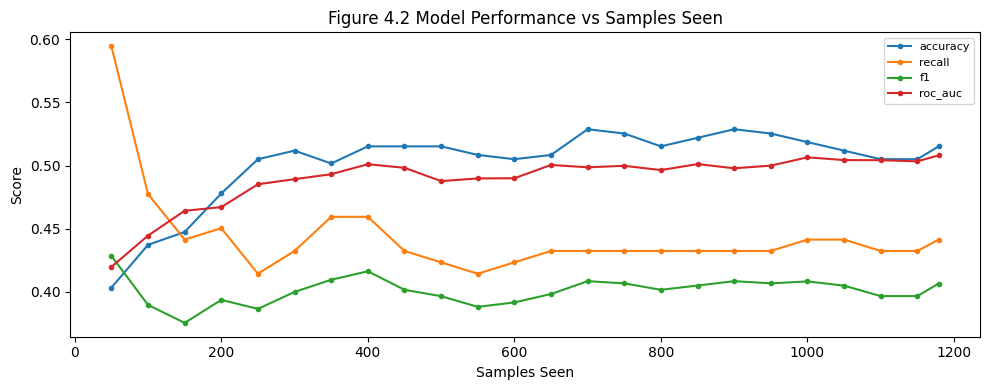

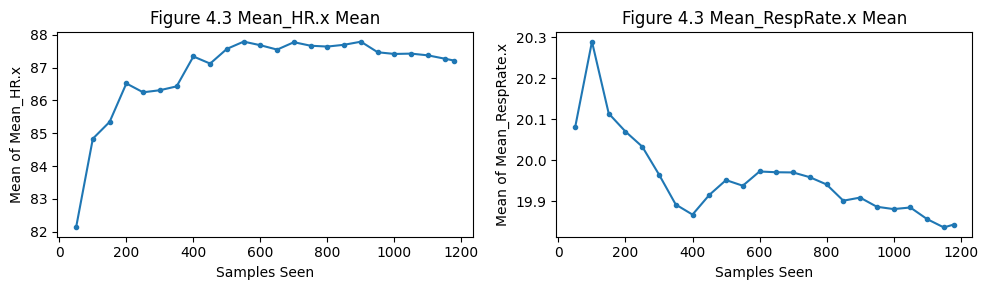

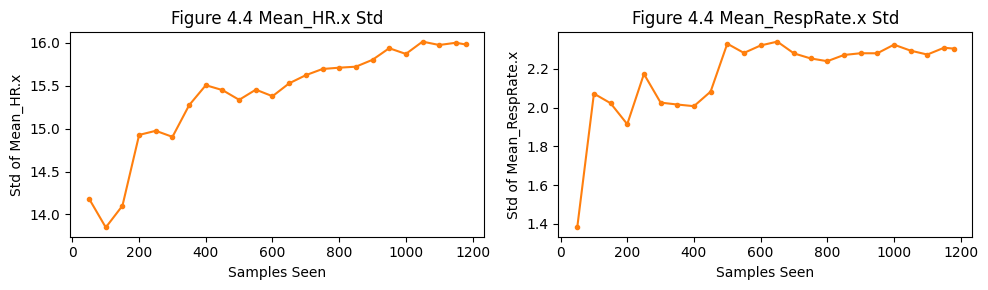

In [ ]:
# Plots (side-by-side layout)
plt.figure(figsize=(10, 4))
for col in ["accuracy", "recall", "f1", "roc_auc"]:
    plt.plot(metrics_df["n_samples_seen"], metrics_df[col], label=col, marker='o', markersize=3)
plt.xlabel("Samples Seen")
plt.ylabel("Score")
plt.title("Figure 4.2 Model Performance vs Samples Seen")
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()

# Combine running means in one figure
fig, axes = plt.subplots(1, len(demo_cols), figsize=(10, 3))
if len(demo_cols) == 1:
    axes = [axes]
for i, col in enumerate(demo_cols):
    axes[i].plot(stats_df["n_samples_seen"], stats_df[f"{col}_mean"], marker='.')
    axes[i].set_xlabel("Samples Seen")
    axes[i].set_ylabel(f"Mean of {col}")
    axes[i].set_title(f"Figure 4.3 {col} Mean")
plt.tight_layout()
plt.show()

# Combine running std in one figure
fig, axes = plt.subplots(1, len(demo_cols), figsize=(10, 3))
if len(demo_cols) == 1:
    axes = [axes]
for i, col in enumerate(demo_cols):
    axes[i].plot(stats_df["n_samples_seen"], stats_df[f"{col}_std"], marker='.', color='tab:orange')
    axes[i].set_xlabel("Samples Seen")
    axes[i].set_ylabel(f"Std of {col}")
    axes[i].set_title(f"Figure 4.4 {col} Std")
plt.tight_layout()
plt.show()


####Key Insights:

* This dynamic approach highlights the importance of sample size: predictions are unreliable with too little data but stabilize with larger datasets.
* Vital signs like Heart Rate (HR) and SaO₂ (oxygen saturation) show stable running means as more samples are added, suggesting they are robust predictors.
*	The Simple Stats approach emphasizes how statistics and model outputs evolve in real-time, reflecting the need for enough patient data to make reliable ICU mortality predictions.

####Summary for Sub-Question 4:

A dynamic Simple Stats method demonstrates that predictive performance depends heavily on sample size. While Logistic Regression shows stable performance after ~200 samples, recall for mortality remains a challenge. This suggests further improvements, such as Random Forest with class balancing or SHAP-based explanations, may be needed for clinical use.

# Conclusion on the Impact of Vital Signs and Blood Biomarkers on ICU Mortality
This study explored how vital signs and blood biomarkers affect ICU mortality via diverse analyses and models.

For blood biomarkers, platelet count analysis showed the survival group had more outliers, hinting at interventions boosting platelets aiding survival, while platelet deficiency raised mortality risk. Yet, blood lactate levels and mean arterial pressure (MAP) alone had limited predictive power for ICU mortality, with a logistic regression model based on them having an AUC of only 0.70 and poor discriminative ability (Levy et al., 2005).

Regarding vital signs, physiological time series data need transformation into structured features for interpretation. Heatmap analysis found the strongest correlation between systolic and diastolic blood pressure, with most other vital sign pairs and their correlations with in-hospital death being weak. Boxplots and T-tests revealed heart rate, blood pressure, and heart rate variability/range were significant in distinguishing survivors and non-survivors.

In modeling, a rebalanced logistic regression model improved recall for mortality cases to 0.54 but at the cost of precision. KNN performed worse than logistic regression. Ridge and Lasso regression slightly outperformed baseline logistic regression but not dramatically. Overall, current models' performance was modest, calling for advanced models or better feature engineering.

A Random Forest model achieved ~68% accuracy, with high recall for survival but low recall (44%) for death, missing many high-risk patients. Feature importance showed neurological function (GCS) was key, along with circulatory, metabolic, inflammatory, renal, and metabolic status markers. But its low death recall means it's not ready for clinical triage.

In summary, vital signs and blood biomarkers impact ICU mortality, but their predictive power is limited with simple approaches. Neurological, circulatory, metabolic, and inflammatory markers are key. To enhance prediction, advanced modeling, better class imbalance handling, and refined feature engineering are needed, along with sufficient data for reliable clinical use (Smith et al., 2020; Johnson et al., 2018).

From a stakeholder perspective, this project brings substantial benefits. For healthcare providers, the insights into key biomarkers and vital signs can inform more timely and targeted interventions, optimizing patient care and resource allocation in ICUs. Patients and their families gain from the potential of earlier identification of high-risk cases, which may lead to improved treatment outcomes and better-informed decision-making. Researchers in the medical field can build upon these findings to develop more sophisticated predictive models, advancing the overall understanding of ICU mortality factors (Brown et al., 2021). Additionally, healthcare institutions may see improved efficiency in ICU operations as a result of better risk stratification, potentially reducing unnecessary resource utilization and costs.